In [1]:
#GIS analysis and data processing algorithm for energy transport systems

#This code aims to provide an universally applicable algorithm for vertical and horizontal aggregation

#Horizontal integration 
# -	Automatically connect any nodes with one another without crossing. (Delaunay Triangulation) - Delaunay tessellation in N dimensions.
# -	Differentiation between land and sea connections. Can we give nodes a condition that if they are close to a coast (e.g. <10km) they act as harbours and can serve connections from land and sea? What if there is just one central node in each country? Can we say at least the node closest to the coast in each country with a sea border needs to contain the harbour property? What if one country connects two different oceans? (e.g. USA?)
# -	Not to many unnecessary connection (e.g. connections that run very close to each other)
# -	Pipeline factor
# -	Waterborne transport around land masses
# - making sure that every point is somehow connected with every other point to ensure feasibility

#Vertical integration
# -	Nodal mismatch
# -	Nodal merging
# - Combination with renewable energy potential geodata

# Backlog for next versions

# - investment modelling
# - toggling regions before clustering
# - integrate Gas grid GGM
# - consideration of storage when crossing countries

# Troubleshooting notes

# - defining candidate connections for pipeline invest
# - focusing on relevant problem at hand - distance between nodes

In [2]:
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from shapely.ops import triangulate
import pandas as pd
import searoute as sr
from matplotlib import pyplot as plt
import numpy as np
from itertools import combinations
from scipy.spatial import Delaunay
import random

In [3]:
#import geopandas included shapefiles
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
capitalcities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#import external datasets, these datasets are currently for visualisation purposes only and are not necessary for the code to work
data_pth_input = "../data/data_input/" #define dataset source folder
cities = gpd.read_file(os.path.join(data_pth_input, "cities/ne_10m_populated_places.shp"))
ports = gpd.read_file(os.path.join(data_pth_input, "ports/WPI.shp"))
rivers = gpd.read_file(os.path.join(data_pth_input, "rivers/world_rivers.shp"))
deepsea = gpd.read_file(os.path.join(data_pth_input, "bm_world_3000mdepth/bm_world_3000mdepthres1.shp"))

#import plexos nodes and h2 terminals proposed locations csv
plexos_nodes = gpd.read_file(os.path.join(data_pth_input, "nodes/nodes.shp"))
new_nodes = pd.read_excel(os.path.join(data_pth_input, "nodes/nodes_and_parameters.xlsx"), sheet_name=0) #einlesen der xlsx in ein dataframe

#data path definition for export files
data_pth_output = "../data/data_output/"

#define model results source folder
data_pth_model_results = "../model/.spinetoolbox/items/spineopttotable_xlsx/output/"

#define data results folder
data_pth_results = "../data/data_results/"

In [4]:
#Centrally define default model parameters

con_flow_cost = 2           #connection flow costs
node_slack_pen = 1000000    #slack penalty cost
con_cap_def = 1000          #default connection capacity
con_cap_pipelines = 1000    #pipeline connection capacity
fix_ratio_io = 1            #default transmission losses
i = 0.06                    #default WACCC
lifetime = 20               #default lifetime
default_invest = 1000       #€/km/MW Pipeline default invest
bts = 0.85                   #share of nodes with balance_type_node
connection_investment_cost = 100
connection_investment_lifetime = "{\"type\": \"duration\", \"data\": \"2D\"}"
time_share = 48/8760        #value that represents the share of connection investment lifetime from a year to be able to scale the investment costs to the investment period
candidate_connections = 100000
connection_flow_cost = 1
ship_speed = 16*1.852       #in km/h equals 13kn
pipeline_elongation_factor = 1.3 #factor by which the length of the pipelines are multiplied to account for non-direct connection between nodes.

In [5]:
#Randomizing functions

#Randomizing function to create an array of random numbers as long as a given dataframe "trans_nodes" and multiply the value by a certain multiplicator "multi" (default = 0 < value < 1)
def randomize(trans_nodes, multi):
    random_nr = []
    rdnr = float
    for ind in trans_nodes.index:
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr

#Randomizing function to create an array of a certain number of random number "anzahl" and multiply the value by a certain multiplicator "multi" (default = 0 < value < 1)
def randomize1(anzahl, multi):
    random_nr = []
    rdnr = float
    for i in range(0, anzahl):
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr


In [6]:
#Dieser Teil im Script ist neu und ermöglicht es flexibler die Knotenpunkte anzupassen (alles bis auf Europa und wenige andere Staaten raus und dann einzelne Bundesländer für Deutschland)
#mit diesem Skript werden aus der Liste aus der neues nodes Datei die einzelnen nodes in ein dataframe geschrieben und die Koordinaten in ein funktionierendes geometry Objekt verpackt.
new_nodes = pd.read_excel(os.path.join(data_pth_input, "nodes/nodes_and_parameters.xlsx"), sheet_name=0) #einlesen der xlsx in ein dataframe
new_nodes = new_nodes.rename(columns={"attribute.1":"attribute_"})  

new_nodes_points = new_nodes.apply(lambda row: Point(row.value1, row.value2), axis=1) #axis=1 macht, dass es von Reihe zu Reihe geht und nicht von Spalte zu Spalte
#first lon then lat
new_nodes_points.head() #hier sind dann die geometry informationen drinne

new_nodes = gpd.GeoDataFrame(new_nodes, geometry=new_nodes_points) #hier werden die geo infos in die neue Spalte geometry im geodataframe eingefügt
new_nodes.crs = {"init": "epsg:4326"} #anpassan der Projektion

new_nodes = new_nodes.drop(columns=["attribute","attribute_","class"])  #deleting unneccesary columns
new_nodes = new_nodes.rename(columns={"value1":"x", "value2":"y"})      #renaming coordinate columns
new_nodes["y"] = new_nodes["y"]*(-1)                                    #transforming latitude values to match Spine GUI requirement - can be left out for other frameworks
new_nodes["h2_node"] = new_nodes['name'] + "_h2"                        #defining name for hydrogen nodes

# #Defining random source nodes (balance type none or node).
bal_ty = []
for c in new_nodes.index:
    if random.random() < bts:                                   #The value compared equals the share of nodes with balance type node
        bal_ty.append("balance_type_node")
    else:
        bal_ty.append("balance_type_none")

new_nodes["balance_type"] = bal_ty
new_nodes["node_slack_penalty"] = node_slack_pen

new_nodes.head()
#plexos_nodes = new_nodes

c:\Users\oliver\mambaforge\envs\geo_tools\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


name          x          y  h2_demand   
0  AF-AGO  17.873887  11.202692   3.684720  \
1  AF-BDI  29.918886   3.373056   0.147396   
2  AF-BEN   2.315834  -9.307690   0.903347   
3  AF-BFA  -1.561593 -12.238333   1.002489   
4  AF-BWA  24.684866  22.328474   0.894621   

   connection_investment_cost_onshore  connection_investment_cost_offshore   
0                          174.120335                           298.492002  \
1                          174.120335                           298.492002   
2                          174.120335                           298.492002   
3                          174.120335                           298.492002   
4                          174.120335                           298.492002   

   connection_investment_lifetime  fix_ratio_out_in_connection_flow   
0                              40                              0.98  \
1                              40                              0.98   
2                              40                              0.98   
3                              40                              0.98   
4                              40                              0.98   

   connection_flow_cost  WACC  ship_investment_cost  fuel_costs   
0                   NaN  0.05           1875.956183         NaN  \
1                   NaN  0.05           1875.956183         NaN   
2                   NaN  0.05           1875.956183         NaN   
3                   NaN  0.05           1875.956183         NaN   
4                   NaN  0.05           1875.956183         NaN   

   fuel_consumption                    geometry    h2_node       balance_type   
0          0.000413  POINT (17.87389 -11.20269)  AF-AGO_h2  balance_type_node  \
1          0.000413   POINT (29.91889 -3.37306)  AF-BDI_h2  balance_type_node   
2          0.000413     POINT (2.31583 9.30769)  AF-BEN_h2  balance_type_node   
3          0.000413   POINT (-1.56159 12.23833)  AF-BFA_h2  balance_type_none   
4          0.000413  POINT (24.68487 -22.32847)  AF-BWA_h2  balance_type_node   

   node_slack_penalty  
0             1000000  
1             1000000  
2             1000000  
3             1000000  
4             1000000

In [7]:
# #randomly generated time series - currently not needed

# def produce_time_series(input_df, ts_name):
#     transfer = input_df
#     zeitreihe = []
#     zeitreihe_str = []
#     monate = ["2015-01-01T00:00:00","2015-02-01T00:00:00","2015-03-01T00:00:00", "2015-04-01T00:00:00", "2015-05-01T00:00:00", "2015-06-01T00:00:00", "2015-07-01T00:00:00", "2015-08-01T00:00:00", "2015-09-01T00:00:00", "2015-10-01T00:00:00", "2015-11-01T00:00:00", "2015-12-01T00:00:00"]
    
#     df_min = randomize1(12, 100)

#     for i in transfer.index:
#         zeitreihe = zeitreihe + ['']            #Platzhalterliste
#         zeitreihe_str = zeitreihe_str + ['']    #Platzhalterliste
#     for j in range(len(transfer)):              #Schleife zum einlesen des Zuflusses ALLER Nodes zu jeweils einer Zeitreihe
#         for i in range(len(monate)-1):          #Schleife zum einlesen des Zuflusses EINES Nodes zu seiner Zeitreihe
#             zeitreihe[j] = zeitreihe[j] + '"' + monate[i] + '": ' + """str(df_min[i])""" + ', '   #min_flow von Monat i, in der Region j
#         zeitreihe[j] = zeitreihe[j].removesuffix(', ')
#         zeitreihe_str[j] = '{"type": "time_series", "data": {' + zeitreihe[j] + '}}'

#     transfer[ts_name] = zeitreihe_str
#     #transfer.cf_timeseries[0]
#     return transfer

# test_df = produce_time_series(new_nodes, "el_demand_ts")
# test_df = produce_time_series(new_nodes, "h2_demand_ts")

In [8]:
#Defining global regions

values = ["Canada", "United States of America"]
north_america = world.loc[world['name'].isin(values)]
values = ["Mexico", "Belize", "Guatemala", "Panama", "Nicaragua", "Costa Rica", "San Jose", "El Salvador", "Honduras"]
central_america = world.loc[world['name'].isin(values)]
values = ["Cuba", "Bahamas", "Trinidad and Tobago", "Haiti", "Dominican Rep.", "Antigua and Barbuda", "Barbados", "Jamaica", "Puerto Rico"]
caribbean = world.loc[world['name'].isin(values)]
values = ["Colombia", "Venezuela", "Guyana", "Suriname", "Brazil", "Argentina", "Uruguay", "Paraguay", "Bolivia", "Falkland Is."]
east_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Ecuador", "Peru", "Chile"]
west_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Norway", "Sweden", "Finland", "Lithuania", "Estonia", "Latvia", "United Kingdom", "Ireland", "Iceland", "Denmark"]
northern_europe = world.loc[world['name'].isin(values)]
values = ["Germany", "Netherlands", "Belgium", "France", "Austria", "Switzerland", "Luxembourg", "Liechtenstein"]
central_europe = world.loc[world['name'].isin(values)]
values = ["Spain", "Portugal", "Italy", "Greece", "Croatia", "Serbia", "Albania", "Montenegro", "Kosovo", "North Macedonia", "Slovenia","Andorra", "Bosnia and Herz.", "Cyprus", "N. Cyprus"]
southern_europe = world.loc[world['name'].isin(values)]
values = ["Poland", "Czechia", "Slovakia", "Hungary", "Romania", "Ukraine", "Moldova", "Bulgaria"]
eastern_europe = world.loc[world['name'].isin(values)]
values = ["Russia", "Belarus"]
russia_belarus = world.loc[world['name'].isin(values)]
values = ["Morocco", "Tunisia", "Egypt", "Algeria", "Libya"]
northern_africa = world.loc[world['name'].isin(values)]
values = ["Chad", "Sudan", "S. Sudan", "Central African Rep.", "Mali", "Niger", "Mauritania", "W. Sahara"]
sahel_zone = world.loc[world['name'].isin(values)]
values = ["Ghana", "Senegal", "Guinea", "Nigeria", "Togo", "Benin", "Burkina Faso", "Côte d'Ivoire", "Sierra Leone", "Liberia", "Gambia", "Guinea-Bissau"]
north_west_coast_africa = world.loc[world['name'].isin(values)]
values = ["Eritrea", "Somalia", "Somaliland", "Ethiopia", "Tanzania", "Kenya","Mozambique", "Madagascar", "Djibouti"]
east_coast_africa = world.loc[world['name'].isin(values)]
values = ["Dem. Rep. Congo", "Gambia", "Botswana", "Burundi", "Rwanda", "Uganda", "Malawi", "Zimbabwe", "Zambia"]
south_central_africa = world.loc[world['name'].isin(values)]
values = ["Angola", "Cameroon", "Congo", "Eq. Guinea", "Gabon"]
west_coast_africa = world.loc[world['name'].isin(values)]
values = ["South Africa", "Namibia", "eSwatini", "Lesotho"]
southern_africa = world.loc[world['name'].isin(values)]
values = ["Iraq", "Syria", "Israel", "Palestine", "Lebanon", "Jordan", "Saudi Arabia", "United Arab Emirates", "Qatar", "Turkey", "Armenia", "Georgia", "Azerbaijan", "Bahrain", "Oman", "Yemen", "Azerbaijan", "Kuwait"]
middle_east = world.loc[world['name'].isin(values)]
values = ["Uzbekistan", "Tajikistan", "Kazakhstan", "Turkmenistan", "Kyrgyzstan"]
central_asia = world.loc[world['name'].isin(values)]
values = ["India", "Afghanistan", "Pakistan", "Iran", "Bangladesh", "Bhutan", "Nepal", "Sri Lanka"]
southern_asia = world.loc[world['name'].isin(values)]
values = ["China", "Japan", "North Korea", "South Korea", "Mongolia", "Taiwan"]
eastern_asia = world.loc[world['name'].isin(values)]
values = ["Indonesia", "Singapore", "Thailand", "Vietnam", "Laos", "Myanmar", "Brunei", "Cambodia", "Malaysia", "Philippines", "Timor-Leste"]
south_eastern_asia = world.loc[world['name'].isin(values)]
values = ["Australia","New Zealand", "Fji", "New Caledonia", "Papua New Guinea", "Solomon Is.", "Vanuatu"]
australia_oceania = world.loc[world['name'].isin(values)]

In [9]:
#Transforming Shapely Points to Numpy Array and triangulating it

tri_work_points = new_nodes["geometry"]

listarray = []
for pp in tri_work_points:
    listarray.append([pp.x, pp.y])
tri_work_array = np.array(listarray)

plexos_nodes_triangulation = Delaunay(tri_work_array)

# Now I have one shapefile with building polygons. I would like to convert them into lines split at each vertex, keeping the original source info as an attribute (Name).
# Use .boundary method to convert the polygons to lines, and .coords to fetch the coordinates of each line segment. Then .explode:
# https://gis.stackexchange.com/questions/436679/how-to-convert-polygons-to-line-segments-using-python

coord_groups = [plexos_nodes_triangulation.points[x] for x in plexos_nodes_triangulation.simplices] #plexos_nodes_triangulation ist eine Variable von weiter oben die die Dreiecke der Delaunay Triangulation beinahtlet und hier in ein gpd Polygon umgebaut wird.
polygons = [Polygon(x) for x in coord_groups]

df = gpd.GeoDataFrame(columns=["geometry"])     #the polygon file is a list array which is now defined as "geometry" attribute of the gdf
df["geometry"] = polygons
df["geometry"] = df.geometry.boundary
dfline = gpd.GeoDataFrame(data=df, geometry='geometry')

def explodeLine(row):
    """A function to return all segments of a line as a list of linestrings"""
    coords = row.geometry.coords #Create a list of all line node coordinates
    parts = []
    for part in zip(coords, coords[1:]): #For each start and end coordinate pair
        parts.append(LineString(part)) #Create a linestring and append to parts list
    return parts

dfline["tempgeom"] = dfline.apply(lambda x: explodeLine(x), axis=1)     #Create a list of all line segments explodeLine(dfline)
dfline = dfline.explode("tempgeom")                                     #Explode it so each segment becomes a row (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html)

dfline = gpd.GeoDataFrame(data=dfline, geometry='tempgeom')
dfline = dfline.drop('geometry', axis=1)
dfline.crs = df.crs                                                     #apply coordinate system
dfline = dfline.rename_geometry("geometry")

dfline = dfline.reset_index()
dfline = dfline.drop("index", axis=1)
dfline["starts_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[0]], axis=1)
dfline["ends_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[-1]], axis=1)

def retracer(df_retracer, station):
    geo_xy = []
    for ind in dfline.index:
        xy = df_retracer.loc[ind][station]
        slc = Point(xy)
        geo_xy.append(slc)
    return geo_xy

dfline["starts"] = retracer(dfline, "starts_temp")
dfline = dfline.drop("starts_temp", axis=1)
dfline["ends"] = retracer(dfline, "ends_temp")
dfline = dfline.drop("ends_temp", axis=1)

nodes_starts = new_nodes[["h2_node", "geometry", "connection_investment_cost_onshore","WACC", "fix_ratio_out_in_connection_flow"]]
nodes_ends = new_nodes[["h2_node", "geometry"]]
nodes_starts = nodes_starts.rename(columns={"h2_node":"h2_node1", "geometry":"starts"})
nodes_ends = nodes_ends.rename(columns={"h2_node":"h2_node2", "geometry":"ends"})
h2_pipelines = dfline.merge(nodes_starts, on="starts", how="left")
h2_pipelines = h2_pipelines.merge(nodes_ends, on="ends", how="left")
h2_pipelines["name"] = h2_pipelines["h2_node1"]+"_"+h2_pipelines["h2_node2"]
h2_pipelines = h2_pipelines.set_geometry("geometry")
h2_pipelines = h2_pipelines.set_crs(4326, allow_override=True)
h2_pipelines = h2_pipelines.drop(columns=["starts","ends"]) #dropping the deepsea pipelines by indexes

# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
h2_pipelines_proj = h2_pipelines.to_crs("ESRI:54012")    #, allow_override=True)
h2_pipelines_proj["length"] = h2_pipelines_proj.length    #calculating the length of the linestring elements
h2_pipelines["length"] = h2_pipelines_proj.length*pipeline_elongation_factor   #pipeline elongation factor

#dropping the very long pipelines (mostly through the arctic)
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
h2_pipelines = h2_pipelines.drop(h2_pipelines[h2_pipelines.length >= 80].index)

#dropping all pipelines crossing the deep sea
poly_union = deepsea.geometry.unary_union #combining all deepsea polygons to one multipolygon
subset = gpd.sjoin(h2_pipelines, deepsea, how='inner', predicate='intersects') #pipelines that cross the deepsea
h2_pipelines = h2_pipelines.drop(index = subset.index) #dropping the deepsea pipelines by indexes

h2_pipelines = h2_pipelines.reindex(columns=["name", "h2_node1", "h2_node2", "geometry", "length", "connection_investment_cost_onshore", "WACC", "fix_ratio_out_in_connection_flow"])

h2_pipelines["connection_flow_cost"] = con_flow_cost
h2_pipelines["connection_capacity"] = con_cap_pipelines #alt. con_cap_def
h2_pipelines["connection_investment_cost"] = h2_pipelines.length*h2_pipelines.connection_investment_cost_onshore*((1+h2_pipelines.WACC)**lifetime/((1+h2_pipelines.WACC)**lifetime-1))*time_share
h2_pipelines["connection_investment_variable_type"] = "variable_type_continuous"
h2_pipelines["connection_investment_lifetime"] = connection_investment_lifetime
h2_pipelines["candidate_connections"] = candidate_connections


#new_nodes.head()
#dfline.head(10)
#nodes_comp.head()
h2_pipelines.head(10)
#h2_pipelines.length
#nodes_starts

C:\Users\oliver\AppData\Local\Temp\ipykernel_23068\3527256124.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h2_pipelines = h2_pipelines.drop(h2_pipelines[h2_pipelines.length >= 80].index)
C:\Users\oliver\AppData\Local\Temp\ipykernel_23068\3527256124.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h2_pipelines["connection_investment_cost"] = h2_pipelines.length*h2_pipelines.connection_investment_cost_onshore*((1+h2_pipelines.WACC)**lifetime/((1+h2_pipelines.WACC)**lifetime-1))*time_share


name      h2_node1      h2_node2   
6      OC-PNG_h2_OC-AUS-QL_h2     OC-PNG_h2  OC-AUS-QL_h2  \
9      EU-FIN_h2_AS-RUS-NW_h2     EU-FIN_h2  AS-RUS-NW_h2   
12  AS-RUS-NW_h2_AS-RUS-SI_h2  AS-RUS-NW_h2  AS-RUS-SI_h2   
13  AS-RUS-SI_h2_AS-RUS-FE_h2  AS-RUS-SI_h2  AS-RUS-FE_h2   
15  AS-RUS-SI_h2_AS-RUS-NW_h2  AS-RUS-SI_h2  AS-RUS-NW_h2   
16  AS-RUS-NW_h2_AS-RUS-UR_h2  AS-RUS-NW_h2  AS-RUS-UR_h2   
17  AS-RUS-UR_h2_AS-RUS-SI_h2  AS-RUS-UR_h2  AS-RUS-SI_h2   
18  NA-USA-AK_h2_NA-CAN-NO_h2  NA-USA-AK_h2  NA-CAN-NO_h2   
21     OC-AUS-WA_h2_AS-TLS_h2  OC-AUS-WA_h2     AS-TLS_h2   
24  OC-AUS-TA_h2_OC-AUS-WA_h2  OC-AUS-TA_h2  OC-AUS-WA_h2   

                                             geometry        length   
6   LINESTRING (143.95555 -6.31499, 145.17972 -24....  3.035865e+06  \
9   LINESTRING (25.74815 61.92411, 49.39031 63.56293)  2.146255e+06   
12  LINESTRING (49.39031 63.56293, 93.19097 58.68187)  4.483381e+06   
13  LINESTRING (93.19097 58.68187, 134.75310 64.61...  3.338421e+06   
15  LINESTRING (93.19097 58.68187, 49.39031 63.56293)  4.483381e+06   
16  LINESTRING (49.39031 63.56293, 61.92033 58.10940)  1.575471e+06   
17  LINESTRING (61.92033 58.10940, 93.19097 58.68187)  2.991607e+06   
18  LINESTRING (-149.68091 64.44596, -116.45058 62...  2.808289e+06   
21  LINESTRING (122.09315 -26.14146, 125.72754 -8....  3.034303e+06   
24  LINESTRING (146.67235 -42.14221, 122.09315 -26...  2.965093e+06   

    connection_investment_cost_onshore  WACC   
6                           174.120335  0.05  \
9                           174.120335  0.05   
12                          174.120335  0.05   
13                          174.120335  0.05   
15                          174.120335  0.05   
16                          174.120335  0.05   
17                          174.120335  0.05   
18                          174.120335  0.05   
21                          174.120335  0.05   
24                          174.120335  0.05   

    fix_ratio_out_in_connection_flow  connection_flow_cost   
6                               0.98                     2  \
9                               0.98                     2   
12                              0.98                     2   
13                              0.98                     2   
15                              0.98                     2   
16                              0.98                     2   
17                              0.98                     2   
18                              0.98                     2   
21                              0.98                     2   
24                              0.98                     2   

    connection_capacity  connection_investment_cost   
6                  1000                   27.561636  \
9                  1000                   36.286867   
12                 1000                   67.481117   
13                 1000                   64.284300   
15                 1000                   67.481117   
16                 1000                   20.923917   
17                 1000                   47.888485   
18                 1000                   50.985058   
21                 1000                   27.018265   
24                 1000                   44.906724   

   connection_investment_variable_type      connection_investment_lifetime   
6             variable_type_continuous  {"type": "duration", "data": "2D"}  \
9             variable_type_continuous  {"type": "duration", "data": "2D"}   
12            variable_type_continuous  {"type": "duration", "data": "2D"}   
13            variable_type_continuous  {"type": "duration", "data": "2D"}   
15            variable_type_continuous  {"type": "duration", "data": "2D"}   
16            variable_type_continuous  {"type": "duration", "data": "2D"}   
17            variable_type_continuous  {"type": "duration", "data": "2D"}   
18            variable_type_continuous  {"type": "duration", "data": "2D"}   
21            variable_type_continuous  {"type": "d

In [10]:
# #dropping the very long pipelines (mostly through the arctic)
# h2_pipelines = dfline.drop(dfline[dfline.length>=5000].index)

# #dropping all pipelines crossing the deep sea
# poly_union = deepsea.geometry.unary_union #combining all deepsea polygons to one multipolygon
# subset = gpd.sjoin(h2_pipelines, deepsea, how='inner', predicate='intersects') #pipelines that cross the deepsea
# h2_pipelines = h2_pipelines.drop(index = subset.index) #dropping the deepsea pipelines by indexes

# h2_pipelines["connection_investment_cost"] = h2_pipelines.length*default_invest*((1+i)**lifetime/((1+i)**lifetime-1))*time_share
# h2_pipelines["connection_investment_lifetime"] = connection_investment_lifetime
# h2_pipelines["connection_investment_variable_type"] = "variable_type_continuous"
# h2_pipelines["candidate_connections"] = candidate_connections

# h2_pipelines

In [11]:
#mit diesem Skript werden aus der Liste aus der proposed_h2_terminals.csv Datei die einzelnen h2 terminals in ein dataframe geschrieben und die Koordinaten in ein funktionierendes geometry Objekt verpackt.
h2_terminals = pd.read_csv(os.path.join(data_pth_input, "proposed_h2_terminals/proposed_h2_terminals.csv"), delimiter=";") #einlesen der csv in ein dataframe

h2_terminal_points = h2_terminals.apply(lambda row: Point(row.longitude, row.latitude), axis=1) #axis=1 macht, dass es von Reihe zu Reihe geht und nicht von Spalte zu Spalte
#first lon then lat
h2_terminal_points.head() #hier sind dann die geometry informationen drinne

h2_terminals = gpd.GeoDataFrame(h2_terminals, geometry=h2_terminal_points) #hier werden die geo infos in die neue Spalte geometry im geodataframe eingefügt
h2_terminals.crs = {"init": "epsg:4326"} #anpassan der Projektion

h2_terminals.head()

c:\Users\oliver\mambaforge\envs\geo_tools\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


name           city    node           region   latitude   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe  51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe  37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe  39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe  45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east  36.825941   

   longitude                   geometry  
0   4.140296   POINT (4.14030 51.94846)  
1  -8.878688  POINT (-8.87869 37.96110)  
2  -0.358820  POINT (-0.35882 39.46371)  
3  12.293656  POINT (12.29366 45.20582)  
4  36.177898  POINT (36.17790 36.82594)

In [12]:
def calculate_searoute(origin, destination):
    origin_lon = h2_terminals.query(f"name=='{origin}'")["longitude"].values
    origin_lat = h2_terminals.query(f"name=='{origin}'")["latitude"].values
    destination_lon = h2_terminals.query(f"name=='{destination}'")["longitude"].values
    destination_lat = h2_terminals.query(f"name=='{destination}'")["latitude"].values
    p_origin = [origin_lon[0], origin_lat[0]]
    p_destination = [destination_lon[0], destination_lat[0]]
    route = sr.searoute(p_origin, p_destination, speed_knot = 13, append_orig_dest= True)
    sr_geo = LineString(route["geometry"]["coordinates"])
    return route["properties"]["duration_hours"], route["properties"]["length"], route["geometry"]["coordinates"], sr_geo

names = (h2_terminals.name.to_list())
combinations_names = np.array(list(combinations(names, 2)))

df_sr = pd.DataFrame(columns=["origin", "destination"])

df_sr["origin"] = combinations_names[:,0]
df_sr["destination"] = combinations_names[:,1]

duration_list = []
length_list = []
coord_list = []
geo_list = []

for i in df_sr.index:
    o = df_sr.iloc[i]["origin"]
    d = df_sr.iloc[i]["destination"]
    duration, length, coord, sr_geo_out = calculate_searoute(o, d)
    duration_list.append(duration)
    length_list.append(length)
    coord_list.append(coord)
    geo_list.append(sr_geo_out)

df_sr["duration_hours"] = duration_list
df_sr["length_km"] = length_list
df_sr["coordinates"] = coord_list
df_sr = gpd.GeoDataFrame(df_sr, geometry=geo_list, crs="EPSG:4326")
df_sr["name"] = df_sr["origin"] + "_" + df_sr["destination"]
df_sr["connection_type"] = "connection_type_normal"
df_sr["fix_ratio_out_in_connection_flow"] = fix_ratio_io
df_sr["connection_capacity"] = con_cap_def
df_sr["connection_flow_cost"] = con_flow_cost

In [13]:
#shipping investment information
df_sr["connection_investment_cost"] = df_sr.length_km*default_invest*((1+i)**lifetime/((1+i)**lifetime-1))*time_share/10000 #/1000 is an arbitrarily chosen value and needs replacement by literature value
df_sr["connection_investment_lifetime"] = connection_investment_lifetime
df_sr["connection_investment_variable_type"] = "variable_type_continuous"
df_sr["candidate_connections"] = candidate_connections

df_sr["connection_delay"] = '{\"type\": \"duration\", \"data\": \"' + (df_sr.length_km/ship_speed).astype(str) + 'h\"}' #km/kmh - connection delay in hours

df_sr

origin            destination  duration_hours   
0       h2_terminal_EU-NLD     h2_terminal_EU-PRT       87.758152  \
1       h2_terminal_EU-NLD     h2_terminal_EU-ESP      142.161685   
2       h2_terminal_EU-NLD     h2_terminal_EU-ITA      238.200563   
3       h2_terminal_EU-NLD     h2_terminal_AS-TUR      264.958636   
4       h2_terminal_EU-NLD     h2_terminal_EU-SWE       84.681372   
..                     ...                    ...             ...   
625     h2_terminal_AF-TZA  h2_terminal_NA-USA-HA      802.412905   
626     h2_terminal_AF-TZA  h2_terminal_OC-AUS-WA      362.734591   
627     h2_terminal_AF-EGY  h2_terminal_NA-USA-HA      854.491681   
628     h2_terminal_AF-EGY  h2_terminal_OC-AUS-WA      479.138395   
629  h2_terminal_NA-USA-HA  h2_terminal_OC-AUS-WA      501.703717   

        length_km                                        coordinates   
0     2112.865259  [[4.140296, 51.948455], [4.047588, 51.835844],...  \
1     3422.684739  [[4.140296, 51.948455], [4.047588, 51.835844],...   
2     5734.916766  [[4.140296, 51.948455], [4.047588, 51.835844],...   
3     6379.144123  [[4.140296, 51.948455], [4.047588, 51.835844],...   
4     2038.788712  [[4.140296, 51.948455], [4.047588, 51.835844],...   
..            ...                                                ...   
625  19318.893102  [[39.704938, -9.969284], [41, -10], [43, -12],...   
626   8733.198013  [[39.704938, -9.969284], [41, -10], [43, -12],...   
627  20572.741717  [[32.449177, 29.916289], [32.6, 29.7], [32.557...   
628  11535.736008  [[32.449177, 29.916289], [32.6, 29.7], [33.75,...   
629  12079.018688  [[-156.012384, 19.735625], [-155, 20], [-157.6...   

                                              geometry   
0    LINESTRING (4.14030 51.94846, 4.04759 51.83584...  \
1    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
2    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
3    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
4    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
..                                                 ...   
625  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
626  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
627  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
628  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
629  LINESTRING (-156.01238 19.73562, -155.00000 20...   

                                            name         connection_type   
0          h2_terminal_EU-NLD_h2_terminal_EU-PRT  connection_type_normal  \
1          h2_terminal_EU-NLD_h2_terminal_EU-ESP  connection_type_normal   
2          h2_terminal_EU-NLD_h2_terminal_EU-ITA  connection_type_normal   
3          h2_terminal_EU-NLD_h2_terminal_AS-TUR  connection_type_normal   
4          h2_terminal_EU-NLD_h2_terminal_EU-SWE  connection_type_normal   
..                                           ...                     ...   
625     h2_terminal_AF-TZA_h2_terminal_NA-USA-HA  connection_type_normal   
626     h2_terminal_AF-TZA_h2_terminal_OC-AUS-WA  connection_type_normal   
627     h2_terminal_AF-EGY_h2_terminal_NA-USA-HA  connection_type_normal   
628     h2_terminal_AF-EGY_h2_terminal_OC-AUS-WA  connection_type_normal   
629  h2_terminal_NA-USA-HA_h2_terminal_OC-AUS-WA  connection_type_normal   

     fix_ratio_out_in_connection_flow  connection_capacity   
0                                   1                 1000  \
1                                   1                 1000   
2                                   1                 1000   
3                                   1                 1000   
4                                   1                 1000   
..                                ...                  ...   
625                                 1                 1000   
626                                 1                 1000   
627                                 1                 1000   
628                                 1                 1000   
629                               

In [14]:
con_line1 = h2_terminals
con_line1 = con_line1.drop(columns=["latitude","longitude"])
con_line1 = con_line1.rename_geometry("geo1")
con_line2 = new_nodes
con_line2 = con_line2.rename_geometry("geo2")
con_line2 = con_line2.rename(columns={"name":"node"})

con_line = con_line1.merge(con_line2, on="node")

con_line_geo = []
for ind in con_line.index:
    coord_t = con_line.loc[ind]["geo1"]
    coord_n = con_line.loc[ind]["geo2"]
    clg = LineString([coord_t, coord_n])
    con_line_geo.append(clg)

con_line = gpd.GeoDataFrame(con_line, geometry=con_line_geo, crs="EPSG:4326")
con_line = con_line.drop(columns=["geo1","geo2"])

# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
con_line_proj = con_line.to_crs("ESRI:54012")    #, allow_override=True)
con_line_proj["length"] = con_line_proj.length    #calculating the length of the linestring elements
con_line["length"] = con_line_proj.length*pipeline_elongation_factor #include pipeline elongation factor

con_line["node2"] = con_line["node"] + "_h2"
con_line = con_line.rename(columns={"name":"node1"})

con_line["name"] = con_line["node1"] + "_" + con_line["node2"]

con_line["connection_type"] = "connection_type_normal"
con_line["connection_capacity"] = con_cap_pipelines #alt. con_cap_def
con_line["connection_flow_cost"] = con_flow_cost
con_line["connection_investment_cost"] = con_line.length*con_line.connection_investment_cost_onshore*((1+i)**lifetime/((1+i)**lifetime-1))*time_share
con_line["connection_investment_variable_type"] = "variable_type_continuous"
con_line["connection_investment_lifetime"] = connection_investment_lifetime
con_line["candidate_connections"] = candidate_connections

con_line.head()


C:\Users\oliver\AppData\Local\Temp\ipykernel_23068\364164155.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  con_line["connection_investment_cost"] = con_line.length*con_line.connection_investment_cost_onshore*((1+i)**lifetime/((1+i)**lifetime-1))*time_share


node1           city    node           region          x   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe   5.291266  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe  -8.224454   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe  -3.749220   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe  12.567380   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east  35.243322   

           y  h2_demand  connection_investment_cost_onshore   
0 -52.132633  21.937496                          174.120335  \
1 -39.399872   5.384917                          174.120335   
2 -40.463667  30.713931                          174.120335   
3 -41.871940  45.251270                          174.120335   
4 -38.963745  71.576451                          174.120335   

   connection_investment_cost_offshore      connection_investment_lifetime   
0                           298.492002  {"type": "duration", "data": "2D"}  \
1                           298.492002  {"type": "duration", "data": "2D"}   
2                           298.492002  {"type": "duration", "data": "2D"}   
3                           298.492002  {"type": "duration", "data": "2D"}   
4                           298.492002  {"type": "duration", "data": "2D"}   

   ...  node_slack_penalty                                           geometry   
0  ...             1000000    LINESTRING (4.14030 51.94846, 5.29127 52.13263)  \
1  ...             1000000  LINESTRING (-8.87869 37.96110, -8.22445 39.39987)   
2  ...             1000000  LINESTRING (-0.35882 39.46371, -3.74922 40.46367)   
3  ...             1000000  LINESTRING (12.29366 45.20582, 12.56738 41.87194)   
4  ...             1000000  LINESTRING (36.17790 36.82594, 35.24332 38.96375)   

          length      node2                          name   
0  119142.021121  EU-NLD_h2  h2_terminal_EU-NLD_EU-NLD_h2  \
1  226214.042537  EU-PRT_h2  h2_terminal_EU-PRT_EU-PRT_h2   
2  400307.915946  EU-ESP_h2  h2_terminal_EU-ESP_EU-ESP_h2   
3  471313.442761  EU-ITA_h2  h2_terminal_EU-ITA_EU-ITA_h2   
4  349209.550854  AS-TUR_h2  h2_terminal_AS-TUR_AS-TUR_h2   

          connection_type connection_capacity connection_investment_cost   
0  connection_type_normal                1000                   1.112093  \
1  connection_type_normal                1000                   1.507964   
2  connection_type_normal                1000                   3.372484   
3  connection_type_normal                1000                   3.191502   
4  connection_type_normal                1000                   2.226031   

   connection_investment_variable_type candidate_connections  
0             variable_type_continuous                100000  
1             variable_type_continuous                100000  
2             variable_type_continuous                100000  
3             variable_type_continuous                100000  
4             variable_type_continuous                100000  

[5 rows x 28 columns]

(-180.0, 180.0)

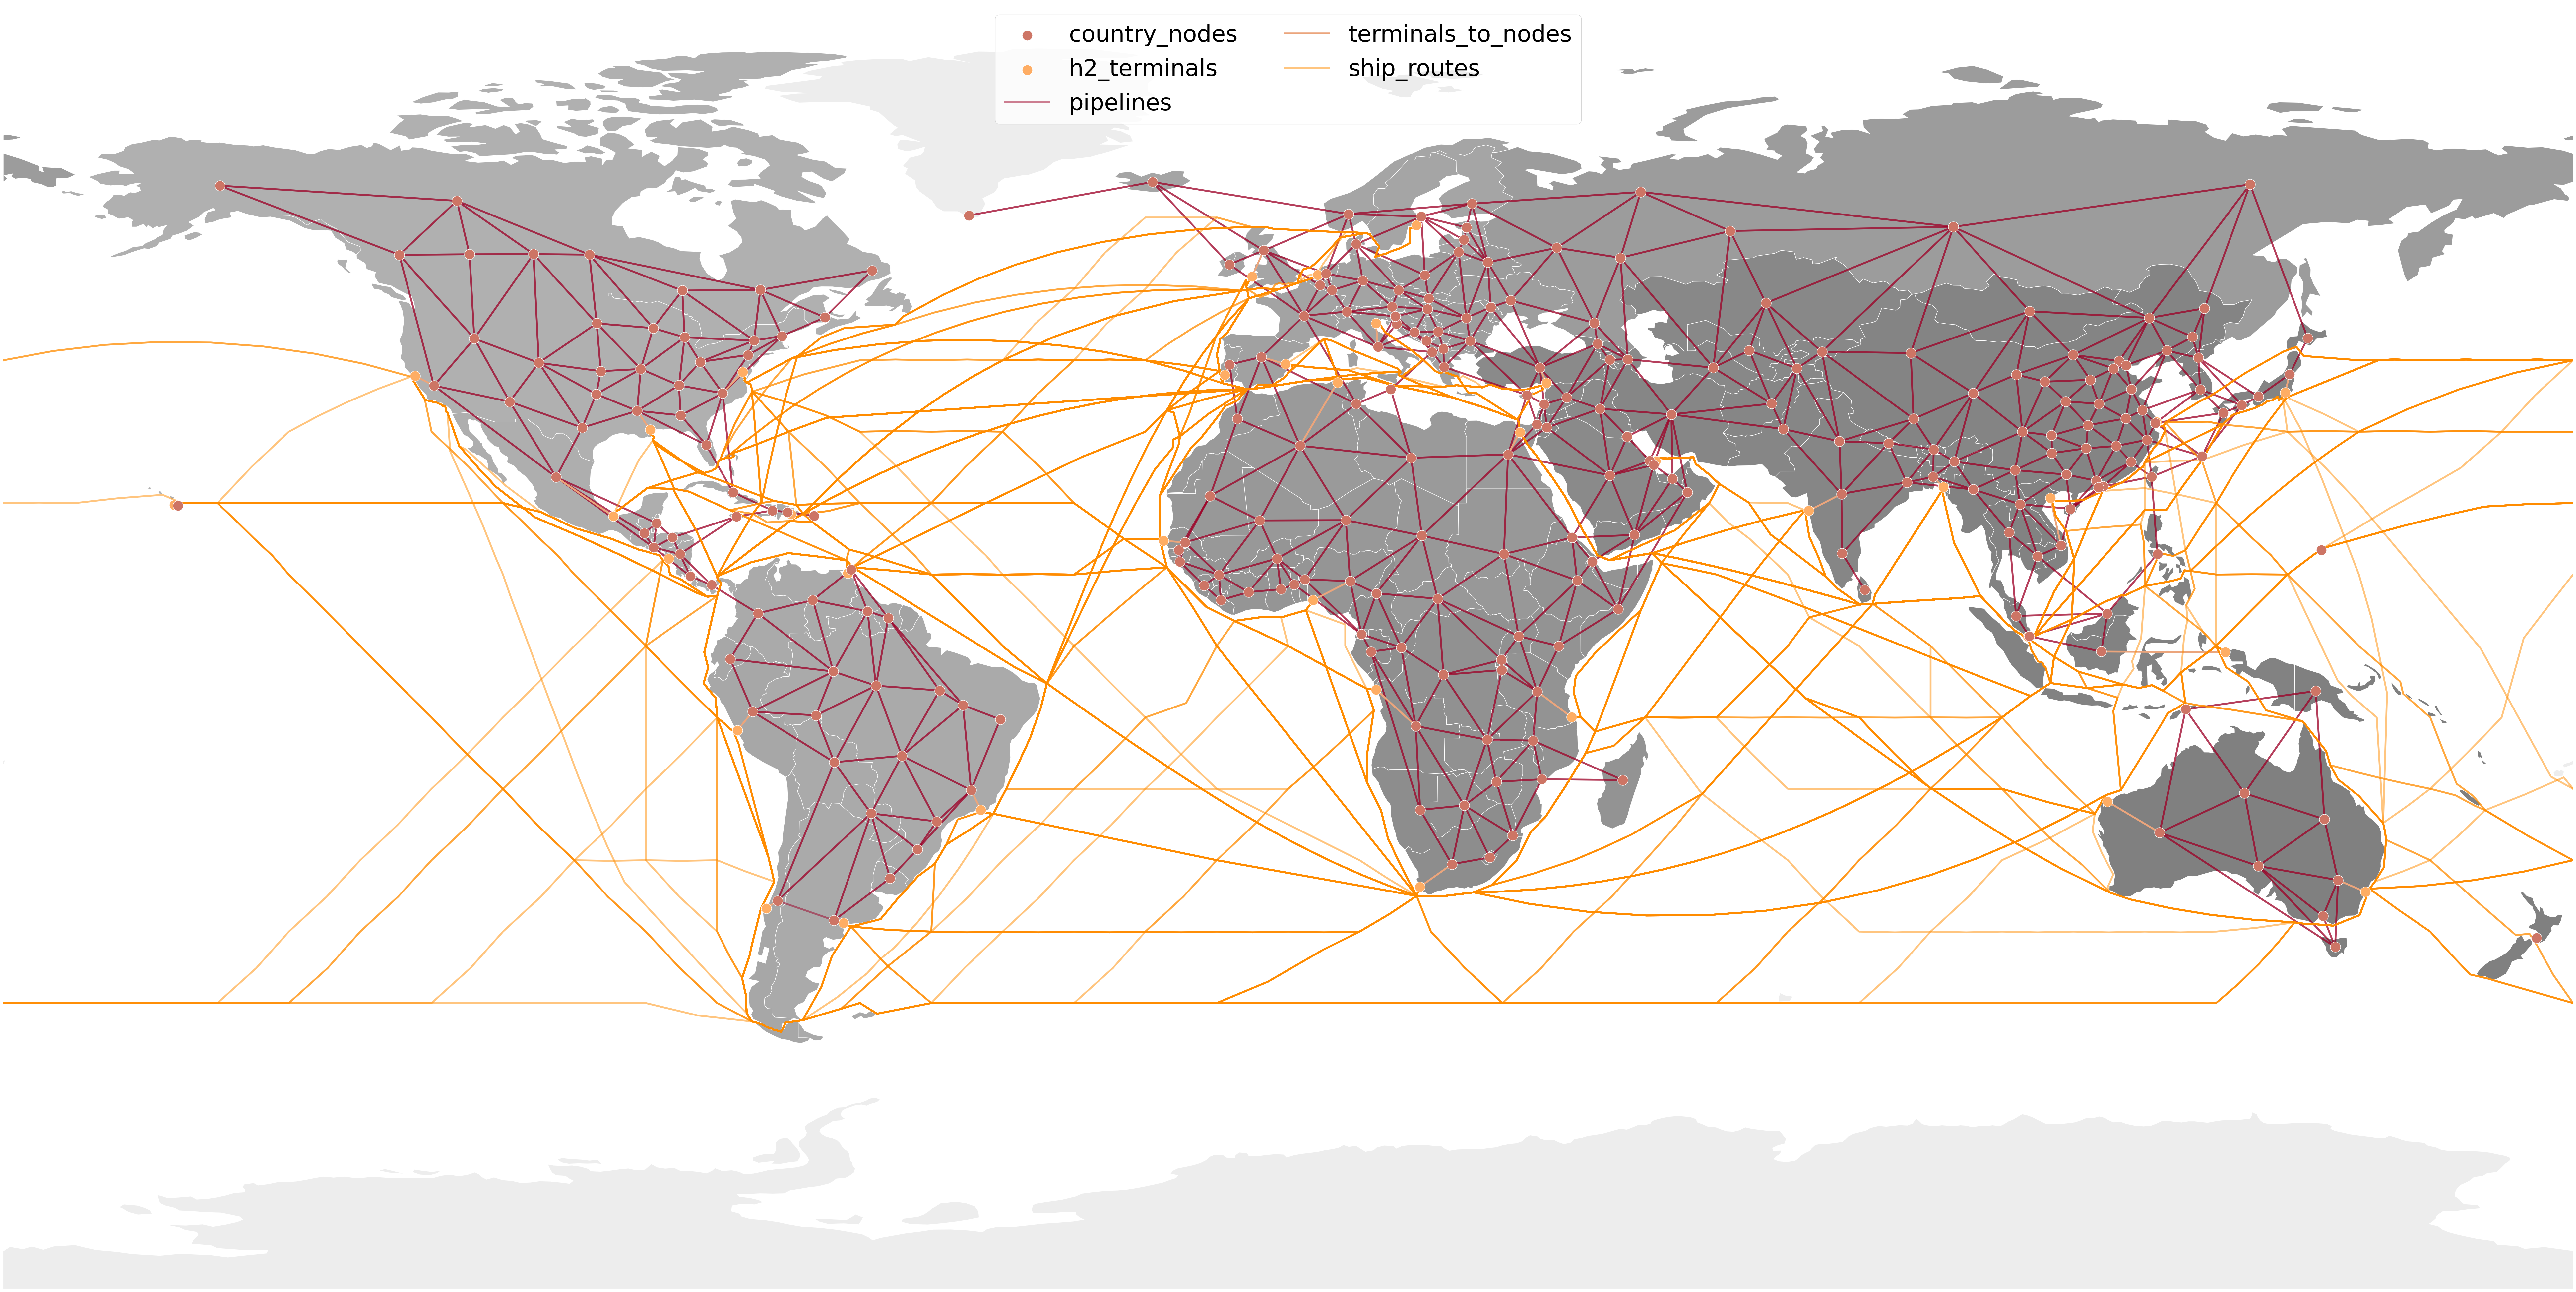

In [15]:
base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
#cities.plot(ax=base, color='black', markersize=10, alpha=0.2)
#ports.plot(ax=base, color='black', markersize=20, alpha=0.2)
#rivers.plot(ax=base, color='blue', markersize=1, alpha=0.1)
new_nodes.plot(ax=base, color='#cd7565', markersize=500, alpha=1, edgecolors='white', label="country_nodes", zorder=3)
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
h2_pipelines.plot(ax=base, color='#9e0027', linewidth=4, edgecolor='white', alpha=0.5, label="pipelines", zorder=1) #Linestringelemente
con_line.plot(ax=base, color='#eba57c', linewidth=4, edgecolor='white', alpha=1, label="terminals_to_nodes", zorder=1) #Linestringelemente
df_sr.plot(ax=base, color='#ff8c00', linewidth=4, edgecolor='white', alpha=0.5, label="ship_routes", zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#deepsea.plot(ax=base, color='blue', markersize=5, edgecolor='white')
base.set_axis_off()
plt.legend(loc="upper center", ncol=2, fontsize=50)
plt.ylim(-90,90)
plt.xlim(-180,180)

Now the exports for Spine will be prepared:

What do I need?
- Nodes (node, node_el, node_h2, balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- h2_terminals (node, node_h2,  balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- connection (node1, node2, name, fix_ratio_out_in_connection_flow, length)
- connection__from_node (node1, node2)
- connection__to_node (node1, node2, connection_capacity)
- cuppling units ()
- unit__node__node ()
- unit__to_node ()
- unit__from_node ()

In [16]:
terminals = h2_terminals
terminals = terminals.rename(columns={"longitude":"x", "latitude":"y"})
terminals["y"] = terminals["y"]*(-1)
terminals["length"] = con_line["length"]
terminals["balance_type"] = "balance_type_node"

terminals.head()

name           city    node           region          y   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe -51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe -37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe -39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe -45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east -36.825941   

           x                   geometry         length       balance_type  
0   4.140296   POINT (4.14030 51.94846)  119142.021121  balance_type_node  
1  -8.878688  POINT (-8.87869 37.96110)  226214.042537  balance_type_node  
2  -0.358820  POINT (-0.35882 39.46371)  400307.915946  balance_type_node  
3  12.293656  POINT (12.29366 45.20582)  471313.442761  balance_type_node  
4  36.177898  POINT (36.17790 36.82594)  349209.550854  balance_type_node

In [17]:
#processing of the prepared dataframes to allow for easier readability in the ESM framework Spine

#1-Dimensional Importer Mappings
#h2_nodes
h2_nodes_concat_bal_ty    = pd.DataFrame({"Object_class_names":"node", "Object names 1":new_nodes.h2_node, "Parameter names":"balance_type", "Alternative names":"Base", "Parameter values":new_nodes.balance_type})
h2_nodes_concat_y    = pd.DataFrame({"Object_class_names":"node", "Object names 1":new_nodes.h2_node, "Parameter names":"x", "Alternative names":"Base", "Parameter values":new_nodes.y})
h2_nodes_concat_x    = pd.DataFrame({"Object_class_names":"node", "Object names 1":new_nodes.h2_node, "Parameter names":"y", "Alternative names":"Base", "Parameter values":new_nodes.x})
h2_nodes_slack_pen    = pd.DataFrame({"Object_class_names":"node", "Object names 1":new_nodes.h2_node, "Parameter names":"node_slack_penalty", "Alternative names":"Base", "Parameter values":node_slack_pen})
h2_nodes_demand    = pd.DataFrame({"Object_class_names":"node", "Object names 1":new_nodes.h2_node, "Parameter names":"demand", "Alternative names":"Base", "Parameter values":new_nodes.h2_demand})
h2_nodes_concat_1D = pd.concat([h2_nodes_concat_bal_ty, h2_nodes_concat_y, h2_nodes_concat_x, h2_nodes_slack_pen, h2_nodes_demand], ignore_index=True)

#h2_terminals
h2_terminals_concat_bal_ty    = pd.DataFrame({"Object_class_names":"node", "Object names 1":terminals.name, "Parameter names":"balance_type", "Alternative names":"Base", "Parameter values":"balance_type_node"})
h2_terminals_concat_y    = pd.DataFrame({"Object_class_names":"node", "Object names 1":terminals.name, "Parameter names":"y", "Alternative names":"Base", "Parameter values":terminals.y})
h2_terminals_concat_x    = pd.DataFrame({"Object_class_names":"node", "Object names 1":terminals.name, "Parameter names":"x", "Alternative names":"Base", "Parameter values":terminals.x})
h2_terminals_concat_1D = pd.concat([h2_terminals_concat_bal_ty, h2_terminals_concat_y, h2_terminals_concat_x], ignore_index=True)

#h2_pipelines
h2_pipelines_concat_cand_con    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":h2_pipelines.name, "Parameter names":"candidate_connections", "Alternative names":"Base", "Parameter values":h2_pipelines.candidate_connections})
h2_pipelines_concat_con_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":h2_pipelines.name, "Parameter names":"connection_type", "Alternative names":"Base", "Parameter values":"connection_type_normal"})
h2_pipelines_concat_inv_cost    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":h2_pipelines.name, "Parameter names":"connection_investment_cost", "Alternative names":"Base", "Parameter values":h2_pipelines.connection_investment_cost})
h2_pipelines_concat_inv_lifetime    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":h2_pipelines.name, "Parameter names":"connection_investment_lifetime", "Alternative names":"Base", "Parameter values":h2_pipelines.connection_investment_lifetime})
h2_pipelines_concat_inv_var_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":h2_pipelines.name, "Parameter names":"connection_investment_variable_type", "Alternative names":"Base", "Parameter values":"variable_type_continuous"})
h2_pipelines_concat_1D = pd.concat([h2_pipelines_concat_cand_con, h2_pipelines_concat_con_type, h2_pipelines_concat_inv_cost, h2_pipelines_concat_inv_lifetime, h2_pipelines_concat_inv_var_type], ignore_index=True)

#h2_terminal connections
h2_terminal_con_concat_cand_con    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":con_line.name, "Parameter names":"candidate_connections", "Alternative names":"Base", "Parameter values":con_line.candidate_connections})
h2_terminal_con_concat_con_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":con_line.name, "Parameter names":"connection_type", "Alternative names":"Base", "Parameter values":"connection_type_normal"})
h2_terminal_con_concat_inv_cost    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":con_line.name, "Parameter names":"connection_investment_cost", "Alternative names":"Base", "Parameter values":con_line.connection_investment_cost})
h2_terminal_con_concat_inv_lifetime    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":con_line.name, "Parameter names":"connection_investment_lifetime", "Alternative names":"Base", "Parameter values":con_line.connection_investment_lifetime})
h2_terminal_con_concat_inv_var_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":con_line.name, "Parameter names":"connection_investment_variable_type", "Alternative names":"Base", "Parameter values":"variable_type_continuous"})
h2_terminal_con_concat_1D = pd.concat([h2_terminal_con_concat_cand_con, h2_terminal_con_concat_con_type, h2_terminal_con_concat_inv_cost, h2_terminal_con_concat_inv_lifetime, h2_terminal_con_concat_inv_var_type], ignore_index=True)

#h2_ship connections
h2_ships_concat_cand_con    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"candidate_connections", "Alternative names":"Base", "Parameter values":df_sr.candidate_connections})
h2_ships_concat_con_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"connection_type", "Alternative names":"Base", "Parameter values":"connection_type_normal"})
h2_ships_concat_inv_cost    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"connection_investment_cost", "Alternative names":"Base", "Parameter values": df_sr.connection_investment_cost})
h2_ships_concat_inv_lifetime    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"connection_investment_lifetime", "Alternative names":"Base", "Parameter values": df_sr.connection_investment_lifetime})
h2_ships_concat_inv_var_type    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"connection_investment_variable_type", "Alternative names":"Base", "Parameter values": "variable_type_continuous"})
#h2_ships_concat_con_delay    = pd.DataFrame({"Object_class_names":"connection", "Object names 1":df_sr.name, "Parameter names":"connection_delay", "Alternative names":"Base", "Parameter values": df_sr.connection_delay})   #connection delay is not included yet due to shortened timescope in testing
h2_ships_concat_1D = pd.concat([h2_ships_concat_cand_con, h2_ships_concat_con_type, h2_ships_concat_inv_cost, h2_ships_concat_inv_lifetime, h2_ships_concat_inv_var_type, h2_ships_concat_inv_var_type], ignore_index=True)

h2_connections_concat_1D = pd.concat([h2_nodes_concat_1D, h2_terminals_concat_1D, h2_pipelines_concat_1D, h2_terminal_con_concat_1D, h2_ships_concat_1D], ignore_index=True) #this dataframe will be exported to the ESM framework

#2-Dimensional Importer Mappings
#h2_pipelines
h2_pipelines_concat_con_cap_f1    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_pipelines})
h2_pipelines_concat_con_cap_f2    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_pipelines})
h2_pipelines_concat_con_cap_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_pipelines})
h2_pipelines_concat_con_cap_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_pipelines})
h2_pipelines_concat_con_flow_cost_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost*2})
h2_pipelines_concat_con_flow_cost_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost*2})
h2_pipelines_concat_2D = pd.concat([h2_pipelines_concat_con_cap_f1, h2_pipelines_concat_con_cap_f2, h2_pipelines_concat_con_cap_t1, h2_pipelines_concat_con_cap_t2, h2_pipelines_concat_con_flow_cost_t1, h2_pipelines_concat_con_flow_cost_t2], ignore_index=True)

#h2_terminal connections
h2_terminal_con_concat_con_cap_f1    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def*1.5})
h2_terminal_con_concat_con_cap_f2    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def*1.5})
h2_terminal_con_concat_con_cap_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def*1.5})
h2_terminal_con_concat_con_cap_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def*1.5})
h2_terminal_con_concat_con_flow_cost_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost*2})
h2_terminal_con_concat_con_flow_cost_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost*2})
h2_terminal_con_concat_2D = pd.concat([h2_terminal_con_concat_con_cap_f1, h2_terminal_con_concat_con_cap_f2, h2_terminal_con_concat_con_cap_t1, h2_terminal_con_concat_con_cap_t2, h2_terminal_con_concat_con_flow_cost_t1, h2_terminal_con_concat_con_flow_cost_t2], ignore_index=True)

#h2_ship connections
h2_ships_concat_con_cap_f1    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def})
h2_ships_concat_con_cap_f2    = pd.DataFrame({"Relationship class names":"connection__from_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def})
h2_ships_concat_con_cap_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def})
h2_ships_concat_con_cap_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_capacity", "Alternative names":"Base", "Parameter values":con_cap_def})
h2_ships_concat_con_flow_cost_t1    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost})
h2_ships_concat_con_flow_cost_t2    = pd.DataFrame({"Relationship class names":"connection__to_node", "Object_class_names":"connection", "Object class names 1":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Parameter names":"connection_flow_cost", "Alternative names":"Base", "Parameter values":connection_flow_cost})
h2_ships_concat_2D = pd.concat([h2_ships_concat_con_cap_f1, h2_ships_concat_con_cap_f2, h2_ships_concat_con_cap_t1, h2_ships_concat_con_cap_t2, h2_ships_concat_con_flow_cost_t1, h2_ships_concat_con_flow_cost_t2], ignore_index=True)

h2_connections_concat_2D = pd.concat([h2_pipelines_concat_2D, h2_terminal_con_concat_2D, h2_ships_concat_2D], ignore_index=True) #this dataframe will be exported to the ESM framework

#3-Dimensional Importer Mappings
#h2_pipelines
h2_pipelines_concat_fix_ratio_io1    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Object names 3":h2_pipelines.h2_node2, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":h2_pipelines.fix_ratio_out_in_connection_flow})
h2_pipelines_concat_fix_ratio_io2    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Object names 3":h2_pipelines.h2_node1, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":h2_pipelines.fix_ratio_out_in_connection_flow})
h2_pipelines_concat_3D = pd.concat([h2_pipelines_concat_fix_ratio_io1, h2_pipelines_concat_fix_ratio_io2], ignore_index=True)

#h2_terminal connections
h2_terminal_con_concat_fix_ratio_io1    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Object names 3":h2_pipelines.h2_node2, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":fix_ratio_io})
h2_terminal_con_concat_fix_ratio_io2    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Object names 3":h2_pipelines.h2_node1, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":fix_ratio_io})
h2_terminal_con_concat_3D = pd.concat([h2_terminal_con_concat_fix_ratio_io1, h2_terminal_con_concat_fix_ratio_io2], ignore_index=True)

#h2_ship connections
h2_ships_concat_fix_ratio_io1    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node1, "Object names 3":h2_pipelines.h2_node2, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":fix_ratio_io})
h2_ships_concat_fix_ratio_io2    = pd.DataFrame({"Relationship class names":"connection__node__node", "Object_class_names":"connection", "Object class names 1":"node", "Object class names 2":"node", "Object names 1":h2_pipelines.name, "Object names 2":h2_pipelines.h2_node2, "Object names 3":h2_pipelines.h2_node1, "Parameter names":"fix_ratio_out_in_connection_flow", "Alternative names":"Base", "Parameter values":fix_ratio_io})
h2_ships_concat_3D = pd.concat([h2_ships_concat_fix_ratio_io1, h2_ships_concat_fix_ratio_io2], ignore_index=True)

h2_connections_concat_3D = pd.concat([h2_pipelines_concat_3D, h2_terminal_con_concat_3D, h2_ships_concat_3D], ignore_index=True) #this dataframe will be exported to the ESM framework

#h2_connections_concat_1D.head()
#h2_connections_concat_2D.head()
h2_connections_concat_3D.head()

Relationship class names Object_class_names Object class names 1   
0   connection__node__node         connection                 node  \
1   connection__node__node         connection                 node   
2   connection__node__node         connection                 node   
3   connection__node__node         connection                 node   
4   connection__node__node         connection                 node   

  Object class names 2             Object names 1 Object names 2   
0                 node     OC-PNG_h2_OC-AUS-QL_h2      OC-PNG_h2  \
1                 node     EU-FIN_h2_AS-RUS-NW_h2      EU-FIN_h2   
2                 node  AS-RUS-NW_h2_AS-RUS-SI_h2   AS-RUS-NW_h2   
3                 node  AS-RUS-SI_h2_AS-RUS-FE_h2   AS-RUS-SI_h2   
4                 node  AS-RUS-SI_h2_AS-RUS-NW_h2   AS-RUS-SI_h2   

  Object names 3                   Parameter names Alternative names   
0   OC-AUS-QL_h2  fix_ratio_out_in_connection_flow              Base  \
1   AS-RUS-NW_h2  fix_ratio_out_in_connection_flow              Base   
2   AS-RUS-SI_h2  fix_ratio_out_in_connection_flow              Base   
3   AS-RUS-FE_h2  fix_ratio_out_in_connection_flow              Base   
4   AS-RUS-NW_h2  fix_ratio_out_in_connection_flow              Base   

   Parameter values  
0              0.98  
1              0.98  
2              0.98  
3              0.98  
4              0.98

In [18]:
# create a excel writer object and export the preprocessed transport model data
with pd.ExcelWriter(os.path.join(data_pth_output, "transport_objects.xlsx")) as writer:
   
    # use to_excel function and specify the sheet_name and index to store the dataframe in specified sheet
    new_nodes.to_excel(writer, sheet_name="nodes", index=False)
    h2_pipelines.to_excel(writer, sheet_name="h2_pipelines", index=False)
    terminals.to_excel(writer, sheet_name="h2_ships", index=False)
    con_line.to_excel(writer, sheet_name="terminal_connections", index=False)
    df_sr.to_excel(writer, sheet_name="shipping_routes", index=False)
    h2_connections_concat_1D.to_excel(writer, sheet_name="h2_connections_1D", index=False)
    h2_connections_concat_2D.to_excel(writer, sheet_name="h2_connections_2D", index=False)
    h2_connections_concat_3D.to_excel(writer, sheet_name="h2_connections_3D", index=False)

Now that the model is exported - from here on the script aims to investigate and visualize the model results

In [22]:
data_pth_model_results = "../model/.spinetoolbox/items/spineopttotable_xlsx/output/" #define model results source folder
h2_pipelines_results = pd.read_excel(os.path.join(data_pth_model_results, "exported_db_url@Output.xlsx"), sheet_name=0, header = None)
#h2_pipelines_results = pd.read_excel(os.path.join(data_pth_model_results, "exported_db_url@Output working h2 flow backup.xlsx"), sheet_name=0, header = None)
h2_pipelines_results = h2_pipelines_results.transpose()
h2_pipelines_results.columns = h2_pipelines_results.iloc[0]
h2_pipelines_results = h2_pipelines_results[1:]
h2_pipelines_results.columns.values[0] = "definition"
h2_pipelines_results.columns.values[2] = "connection_type"

ship_con_results = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_pos"].index)

h2_pipelines_results

0                                definition                 node   
1                           connection_flow  AF-AGO_h2_AF-BWA_h2  \
2                           connection_flow  AF-AGO_h2_AF-BWA_h2   
3                           connection_flow  AF-AGO_h2_AF-BWA_h2   
4                           connection_flow  AF-AGO_h2_AF-BWA_h2   
5                           connection_flow  AF-AGO_h2_AF-COD_h2   
...                                     ...                  ...   
8618        objective_connection_flow_costs               simple   
8619  objective_connection_investment_costs               simple   
8620                   objective_fuel_costs               simple   
8621                        objective_taxes               simple   
8622                            total_costs               simple   

0    connection_type stochastic_scenario 2000-01-01T00:00:00   
1          from_node           AF-AGO_h2                   0  \
2          from_node           AF-BWA_h2                   0   
3            to_node           AF-AGO_h2                   0   
4            to_node           AF-BWA_h2                   0   
5          from_node           AF-AGO_h2                   0   
...              ...                 ...                 ...   
8618             NaN                 NaN       135886.283737   
8619             NaN                 NaN            1.233795   
8620             NaN                 NaN                   0   
8621             NaN                 NaN                   0   
8622             NaN                 NaN     21678231.393762   

0    2000-01-02T00:00:00  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
...                  ...  
8618                 NaN  
8619                 NaN  
8620                 NaN  
8621                 NaN  
8622                 NaN  

[8622 rows x 6 columns]

In [23]:
#import model  result data
h2_pipelines_results = pd.read_excel(os.path.join(data_pth_model_results, "exported_db_url@Output.xlsx"), sheet_name=0, header = None)
h2_pipelines_results = h2_pipelines_results.transpose()
h2_pipelines_results.columns = h2_pipelines_results.iloc[0]
h2_pipelines_results = h2_pipelines_results[1:]
h2_pipelines_results.columns.values[0] = "definition"
h2_pipelines_results.columns.values[2] = "connection_type"

#preprocessing of nodal results
node_slack_pos = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_pos"].index)
node_slack_pos = node_slack_pos.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_slack_pos = node_slack_pos.rename(columns={"node":"h2_node"})
node_slack_pos = new_nodes.merge(node_slack_pos, how="left")
node_slack_pos = node_slack_pos.rename(columns={"2000-01-01T00:00:00":"slack_p"})

node_slack_neg = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_neg"].index)
node_slack_neg = node_slack_neg.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_slack_neg = node_slack_neg.rename(columns={"node":"h2_node"})
node_slack_neg = node_slack_pos.merge(node_slack_neg, how="left")
node_slack_neg = node_slack_neg.rename(columns={"2000-01-01T00:00:00":"slack_n"})

node_injection = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_injection"].index)
node_injection = node_injection.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_injection = node_injection.rename(columns={"node":"h2_node"})
node_injection = node_slack_neg.merge(node_injection, how="left")
node_injection = node_injection.rename(columns={"2000-01-01T00:00:00":"injection"})
# node_injection["value"] = node_injection["value"].abs() #optional if representation shall be as dot diameter and not in a bar graph

#preprocessing of pipeline results
h2_pipelines_results = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["connection_type"] != "from_node"].index)
h2_pipelines_results = h2_pipelines_results.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
h2_pipelines_results = h2_pipelines_results.rename(columns={"node":"name", "2000-01-01T00:00:00":"flow"})
h2_shipping_results = df_sr.merge(h2_pipelines_results, how="left")
# #max_flow_pipeline = h2_pipelines_results["flow"].max()
h2_conline_results = con_line.merge(h2_pipelines_results, how="left")
# #max_flow_terminal = h2_conline_results["flow"].max()
h2_pipelines_results = h2_pipelines.merge(h2_pipelines_results, on="name", how="left")
# #max_flow_ship = h2_shipping_results["flow"].max()

node_results = node_injection #binding together the results for slack and injection with the original demand information of the nodes

#preprocessing of node information
node_results_none = node_results.drop(node_results[node_results["balance_type"] == "balance_type_node"].index)
#node_results_none = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["connection_flow"] > 0]) # attempt to filter by positive flow connection_from_node ti identifiy the source nodes and their outflows

#h2_pipelines
# #df_sr_results
# test_df_none
# node_slack_pos
# node_injection
# node_results_none
#h2_pipelines_results.head(5)
#h2_shipping_results.head(5)
h2_conline_results.head(5)
# print(max_flow_pipeline)
# print(max_flow_terminal)
# print(max_flow_ship)
#test_df_none_2

node1           city    node           region          x   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe   5.291266  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe  -8.224454   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe  -3.749220   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe  12.567380   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east  35.243322   

           y  h2_demand  connection_investment_cost_onshore   
0 -52.132633  21.937496                          174.120335  \
1 -39.399872   5.384917                          174.120335   
2 -40.463667  30.713931                          174.120335   
3 -41.871940  45.251270                          174.120335   
4 -38.963745  71.576451                          174.120335   

   connection_investment_cost_offshore      connection_investment_lifetime   
0                           298.492002  {"type": "duration", "data": "2D"}  \
1                           298.492002  {"type": "duration", "data": "2D"}   
2                           298.492002  {"type": "duration", "data": "2D"}   
3                           298.492002  {"type": "duration", "data": "2D"}   
4                           298.492002  {"type": "duration", "data": "2D"}   

   ...                                           geometry         length   
0  ...    LINESTRING (4.14030 51.94846, 5.29127 52.13263)  119142.021121  \
1  ...  LINESTRING (-8.87869 37.96110, -8.22445 39.39987)  226214.042537   
2  ...  LINESTRING (-0.35882 39.46371, -3.74922 40.46367)  400307.915946   
3  ...  LINESTRING (12.29366 45.20582, 12.56738 41.87194)  471313.442761   
4  ...  LINESTRING (36.17790 36.82594, 35.24332 38.96375)  349209.550854   

       node2                          name         connection_type   
0  EU-NLD_h2  h2_terminal_EU-NLD_EU-NLD_h2  connection_type_normal  \
1  EU-PRT_h2  h2_terminal_EU-PRT_EU-PRT_h2  connection_type_normal   
2  EU-ESP_h2  h2_terminal_EU-ESP_EU-ESP_h2  connection_type_normal   
3  EU-ITA_h2  h2_terminal_EU-ITA_EU-ITA_h2  connection_type_normal   
4  AS-TUR_h2  h2_terminal_AS-TUR_AS-TUR_h2  connection_type_normal   

   connection_capacity connection_investment_cost   
0                 1000                   1.112093  \
1                 1000                   1.507964   
2                 1000                   3.372484   
3                 1000                   3.191502   
4                 1000                   2.226031   

  connection_investment_variable_type  candidate_connections flow  
0            variable_type_continuous                 100000  NaN  
1            variable_type_continuous                 100000  NaN  
2            variable_type_continuous                 100000  NaN  
3            variable_type_continuous                 100000  NaN  
4            variable_type_continuous                 100000  NaN  

[5 rows x 29 columns]

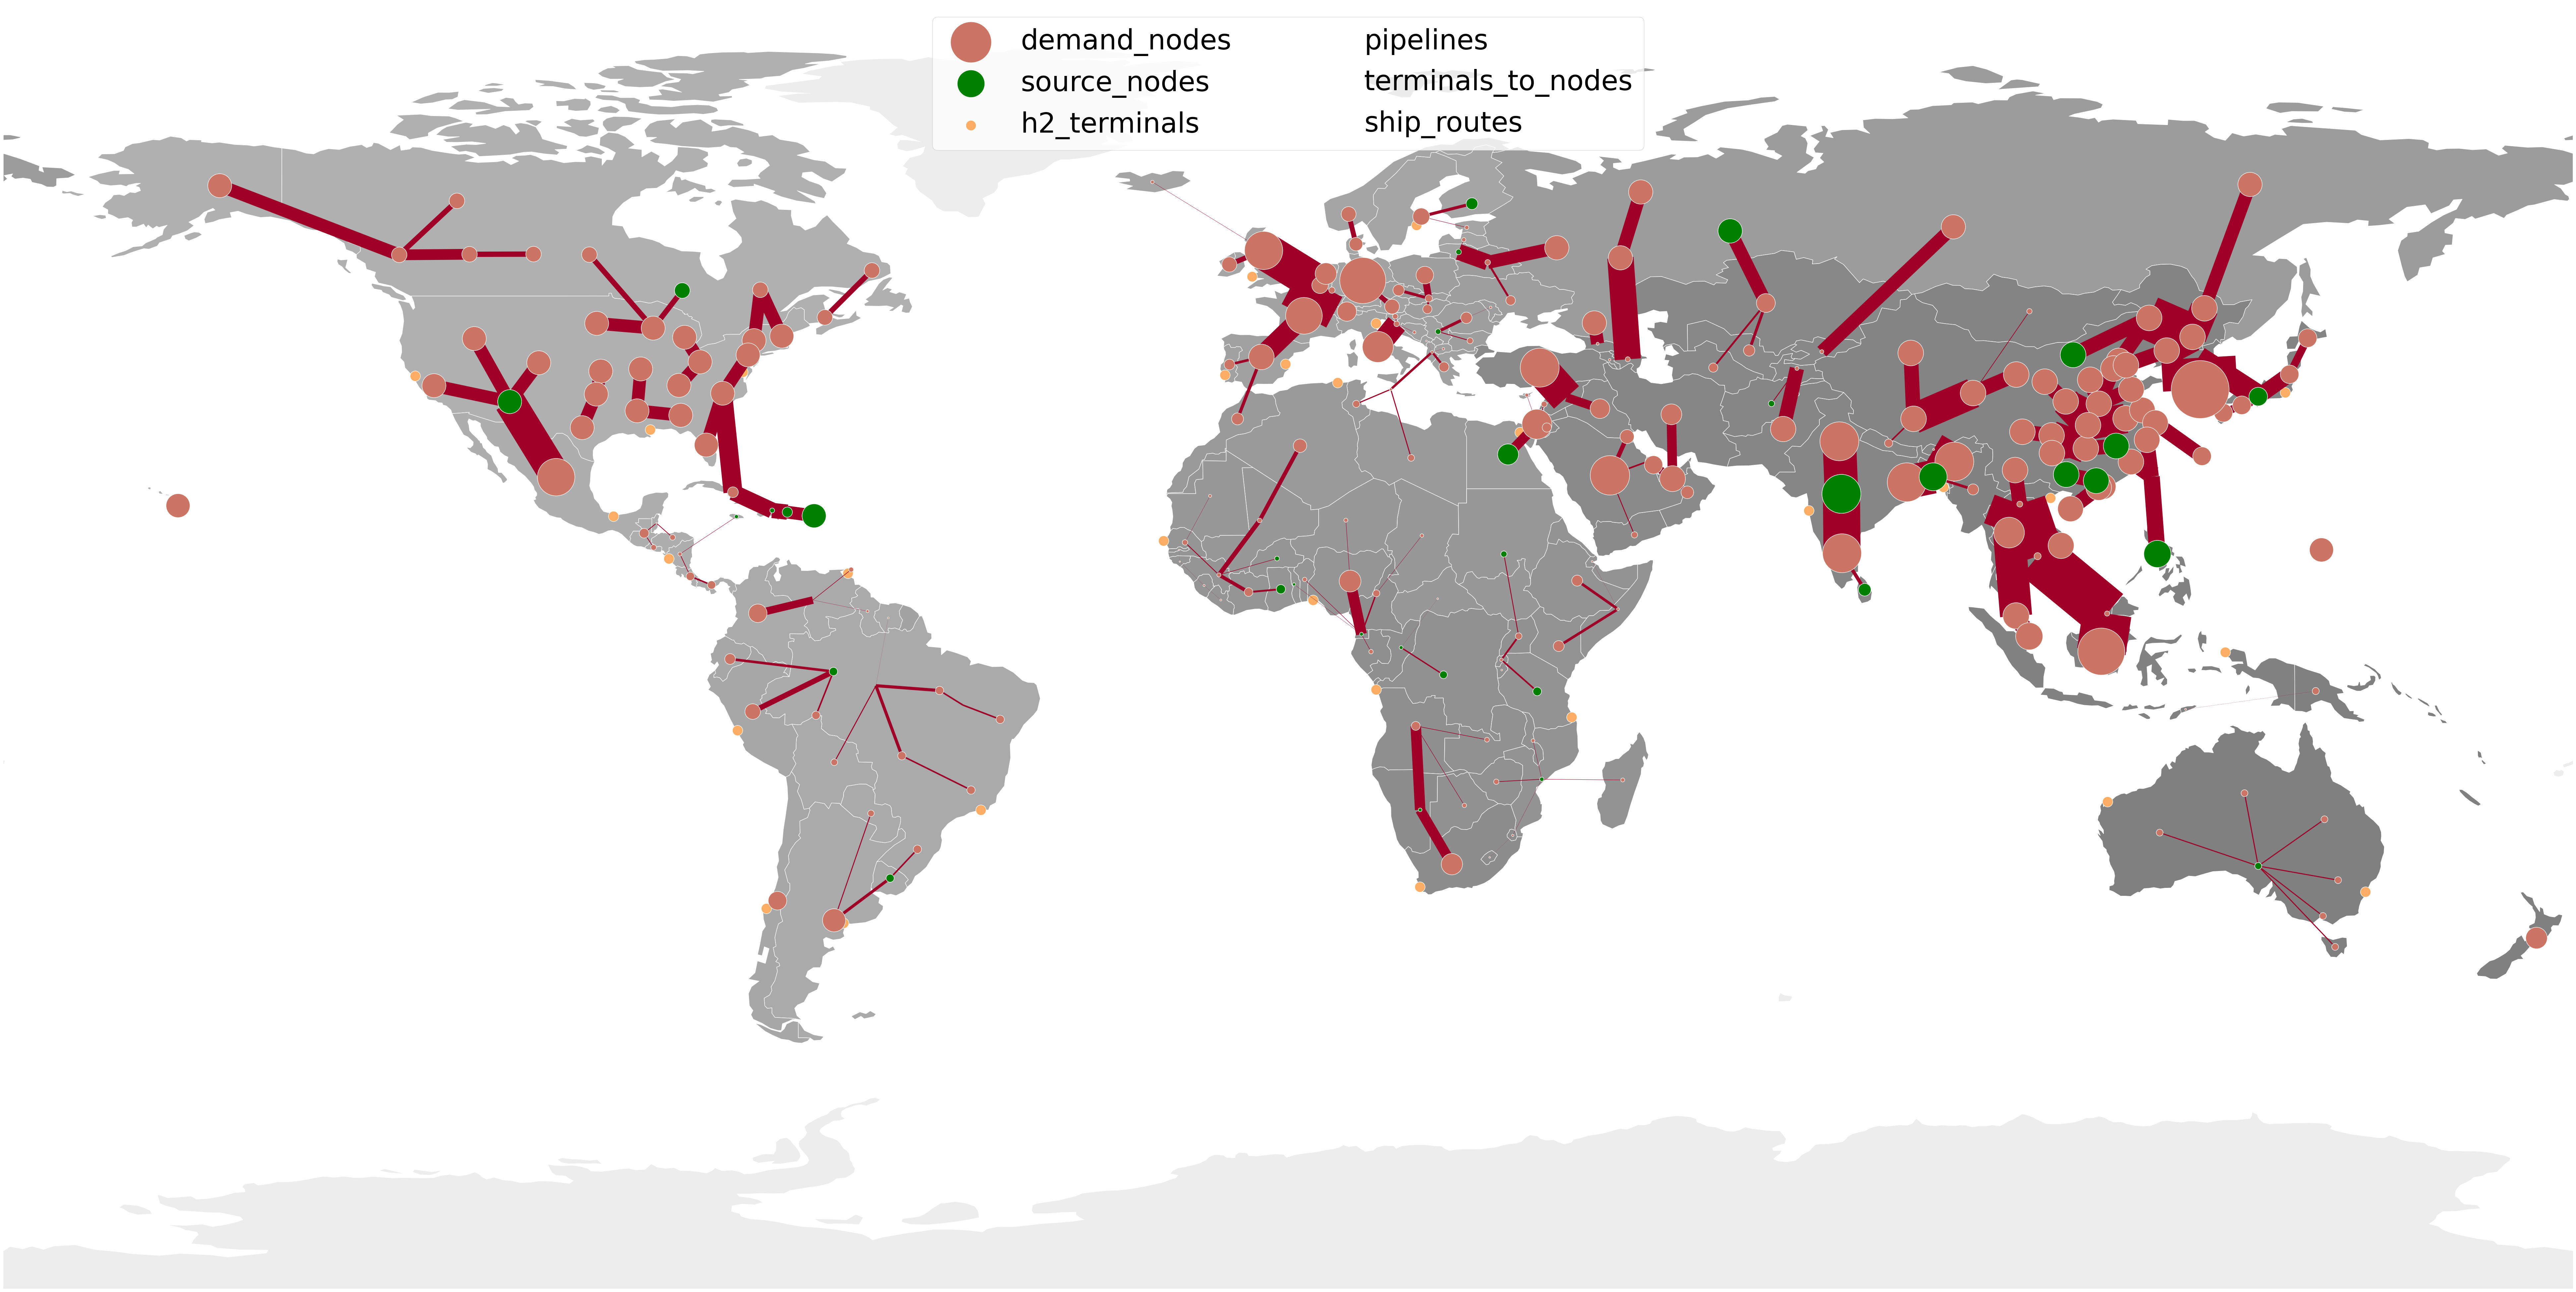

In [24]:
#How to insert bar charts into map diagrams
#code source: https://stackoverflow.com/questions/55854988/subplots-onto-a-basemap/55890475#55890475
#https://stackoverflow.com/questions/75825601/how-can-i-add-bar-charts-at-certain-locations-to-a-geopandas-map-using-the-same/75848560#75848560


#from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import matplotlib.patches as mpatches

# function to create inset axes and plot bar chart on it
# this is good for 3 items bar chart
def build_bar(mapx, mapy, ax, width, xvals=['a','b','c'], yvals=[1,4,2], fcolors=['r','y','b']):
    ax_h = inset_axes(ax, width=width, \
                    height=width, \
                    loc=3, \
                    bbox_to_anchor=(mapx, mapy), \
                    bbox_transform=ax.transData, \
                    borderpad=0, \
                    axes_kwargs={'alpha': 0.35, 'visible': True})
    for x,y,c in zip(xvals, yvals, fcolors):
        ax_h.bar(x, y, label=str(x), fc=c)
    #ax.xticks(range(len(xvals)), xvals, fontsize=10, rotation=30)
    ax_h.axis('off')
    return ax_h

base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
node_results.plot(ax=base, color='#cd7565', markersize=node_results["h2_demand"]*100, alpha=1, edgecolors='white', label="demand_nodes", zorder=4) #demand overlay
node_results_none.plot(ax=base, color='green', markersize=node_results_none["h2_demand"]*100, alpha=1, edgecolors='white', label="source_nodes", zorder=5) #balance_type differentiation
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
h2_pipelines_results.plot(ax=base, color='#9e0027', linewidth=h2_pipelines_results['flow'], alpha=1, label="pipelines", zorder=2) #/(max_flow_pipeline+0.01)*100 h2_pipelines_results['flow']/max_flow_pipeline*1000 vmin=0, vmax=1
h2_conline_results.plot(ax=base, color='#eba57c', linewidth=h2_conline_results['flow'], alpha=1, label="terminals_to_nodes", zorder=2) #column='name',
h2_shipping_results.plot(ax=base, color='#ff8c00', linewidth=h2_shipping_results['flow'], alpha=1, label="ship_routes", zorder=2) #column='name',
plt.legend(loc="upper center", ncol=2, fontsize=60)
plt.ylim(-90,90)
plt.xlim(-180,180)

# #create a barchart at each location in (lon1s,lat1s)
# bar_width = 0.1  # inch
# colors = ['orange','purple','red']
# for i in node_results.index:
#     x1 = node_results["x"][i]   # get data coordinates for plotting
#     y1 = node_results["y"][i]*(-1)   # get data coordinates for plotting
#     bax = build_bar(x1, y1, base, width=0.5, xvals=("h2_demand", "injection", "slack_n"), \
#               yvals = [node_results["h2_demand"][i], node_results["injection"][i], node_results["slack_n"][i]], \
#               fcolors=colors)

base.set_axis_off()

#über colorband machen? https://matplotlib.org/stable/tutorials/colors/colormaps.html